<img src="NLP Group Logo.png" alt="sample image" width="1000" height="200">

In [1]:
!pip install nltk
!pip install contractions

In [2]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import contractions
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Download NLTK resources (only run once)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Katy
[nltk_data]     Sonnekus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Katy
[nltk_data]     Sonnekus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [5]:
# Load data
df_train = pd.read_csv('train.csv')
df_test= pd.read_csv('test.csv')

Data Cleaning

In [6]:
# Combine text fields
df_train['full_text'] = df_train['headlines'].fillna('') + ' ' + df_train['description'].fillna('') + ' ' + df_train['content'].fillna('')
df_test['full_text'] = df_test['headlines'].fillna('') + ' ' + df_test['description'].fillna('') + ' ' + df_test['content'].fillna('')

In [7]:
# Define text cleaning function
def clean_text(text):
     text = contractions.fix(text)  # expand contractions
     text = text.lower()
     text = re.sub(r"http\S+", "", text)  # remove URLs
     text = BeautifulSoup(text, "html.parser").get_text()  # remove HTML tags
     text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
     text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace
     text = re.sub(r'\d+', '', text)  # remove numbers
     tokens = text.split()
     tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
     return ' '.join(tokens)
    
df_train['processed_text'] = df_train['full_text'].apply(clean_text)
df_test['processed_text'] = df_test['full_text'].apply(clean_text)

In [8]:
print(df_train.columns.tolist())
print(df_test.columns.tolist())

['headlines', 'description', 'content', 'url', 'category', 'full_text', 'processed_text']
['headlines', 'description', 'content', 'url', 'category', 'full_text', 'processed_text']


In [9]:
# Check for duplicates in train.csv
train_duplicates = df_train.duplicated().sum()
print(f"Number of duplicate rows in train.csv: {train_duplicates}")

# Check for duplicates in test.csv
test_duplicates = df_test.duplicated().sum()
print(f"Number of duplicate rows in test.csv: {test_duplicates}")

Number of duplicate rows in train.csv: 0
Number of duplicate rows in test.csv: 0


In [10]:
# Check for missing values in train.csv
print("Missing values in train.csv:")
print(df_train.isnull().sum())

# Check for missing values in test.csv
print("\nMissing values in test.csv:")
print(df_test.isnull().sum())

Missing values in train.csv:
headlines         0
description       0
content           0
url               0
category          0
full_text         0
processed_text    0
dtype: int64

Missing values in test.csv:
headlines         0
description       0
content           0
url               0
category          0
full_text         0
processed_text    0
dtype: int64


In [ ]:
import requests
# Function to validate URLs
def validate_url(url):
    try:
        response = requests.head(url, allow_redirects=True, timeout=5)
        return response.status_code == 200
    except requests.RequestException:
        return False

# Validate URLs in train.csv
df_train['url_valid'] = df_train['url'].apply(validate_url)
invalid_train_urls = df_train[~df_train['url_valid']].shape[0]
print(f"Number of invalid or unreachable URLs in train.csv: {invalid_train_urls}")

# Validate URLs in test.csv
df_test['url_valid'] = df_test['url'].apply(validate_url)
invalid_test_urls = df_test[~df_test['url_valid']].shape[0]
print(f"Number of invalid or unreachable URLs in test.csv: {invalid_test_urls}")

Standardise & Group Categories

In [11]:
# Function to standardize and group categories
def standardize_category(category):
    category = category.lower()
    if category in ['business', 'economy', 'market']:
        return 'business'
    elif category in ['sports', 'cricket', 'football', 'tennis']:
        return 'sports'
    elif category in ['technology', 'tech', 'ai', 'privacy']:
        return 'technology'
    elif category in ['education', 'admissions', 'scholarships', 'policy']:
        return 'education'
    elif category in ['entertainment', 'bollywood', 'hollywood', 'cinema']:
        return 'entertainment'
    else:
        return 'miscellaneous'

# Apply the function
df_train['category'] = df_train['category'].apply(standardize_category)
df_test['category'] = df_test['category'].apply(standardize_category)

print("Category standardization and grouping completed.")

Category standardization and grouping completed.


In [26]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_train['category'])

In [13]:
# Feature Extraction and CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=1000)
X_train = vectorizer.fit_transform(df_train['processed_text'])
X_test = vectorizer.transform(df_test['processed_text'])

In [14]:
# Split data
y = label_encoder.transform(df_train['category'])  # Already processed
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y, test_size=0.2, random_state=42
)

Create model

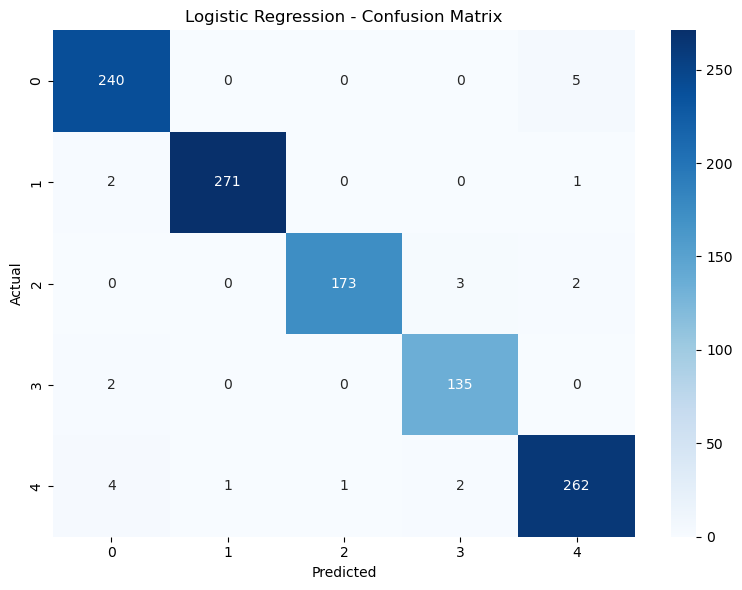


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       245
           1       1.00      0.99      0.99       274
           2       0.99      0.97      0.98       178
           3       0.96      0.99      0.97       137
           4       0.97      0.97      0.97       270

    accuracy                           0.98      1104
   macro avg       0.98      0.98      0.98      1104
weighted avg       0.98      0.98      0.98      1104



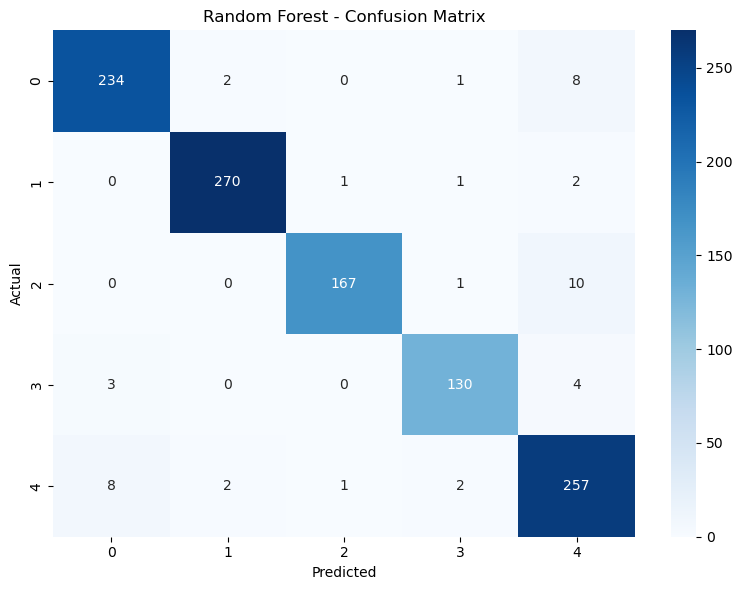


Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       245
           1       0.99      0.99      0.99       274
           2       0.99      0.94      0.96       178
           3       0.96      0.95      0.96       137
           4       0.91      0.95      0.93       270

    accuracy                           0.96      1104
   macro avg       0.96      0.96      0.96      1104
weighted avg       0.96      0.96      0.96      1104



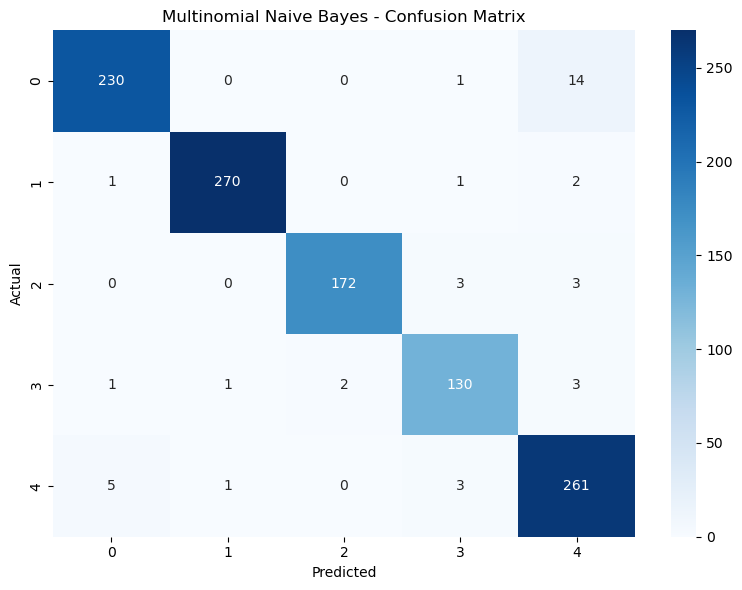


Multinomial Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       245
           1       0.99      0.99      0.99       274
           2       0.99      0.97      0.98       178
           3       0.94      0.95      0.95       137
           4       0.92      0.97      0.94       270

    accuracy                           0.96      1104
   macro avg       0.96      0.96      0.96      1104
weighted avg       0.96      0.96      0.96      1104



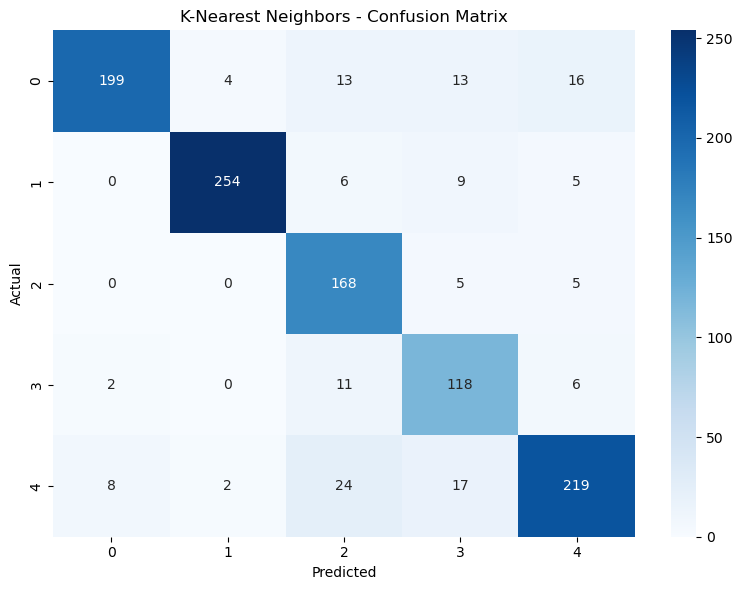


K-Nearest Neighbors - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88       245
           1       0.98      0.93      0.95       274
           2       0.76      0.94      0.84       178
           3       0.73      0.86      0.79       137
           4       0.87      0.81      0.84       270

    accuracy                           0.87      1104
   macro avg       0.86      0.87      0.86      1104
weighted avg       0.88      0.87      0.87      1104



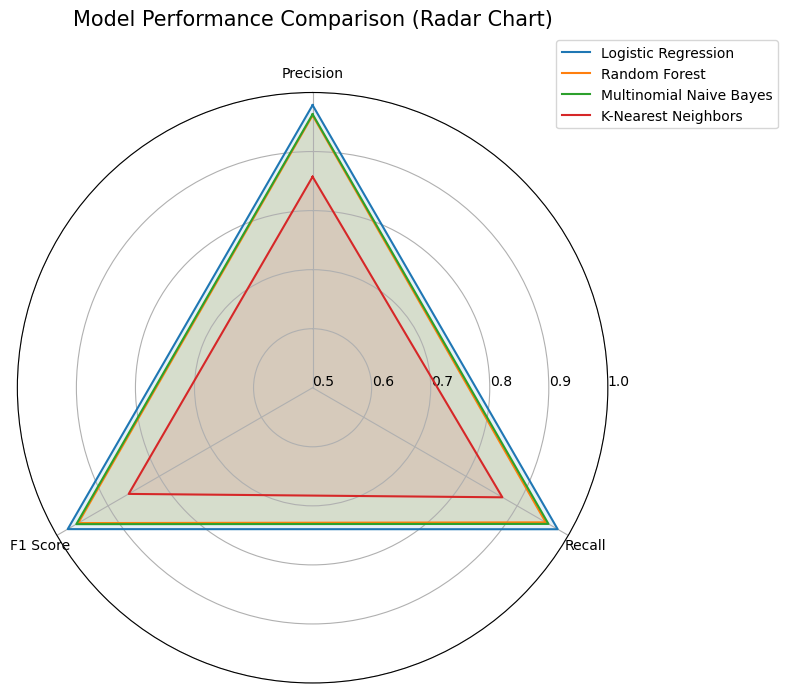

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [15]:
# Function to train, predict and visualize confusion matrix
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Classification Report
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred))

    # Get macro-averaged scores
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']

    return precision, recall, f1

models = [
    (LogisticRegression(max_iter=1000), "Logistic Regression"),
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
    (MultinomialNB(), "Multinomial Naive Bayes"),
    (KNeighborsClassifier(n_neighbors=5), "K-Nearest Neighbors")
]

# Store performance scores
model_names = []
precision_scores = []
recall_scores = []
f1_scores = []

for model, name in models:
    precision, recall, f1 = evaluate_model(model, name, X_train_split, y_train_split, X_val_split, y_val_split)
    model_names.append(name)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

labels = ['Precision', 'Recall', 'F1 Score']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

def add_to_radar(ax, values, label):
    values += values[:1]
    ax.plot(angles, values, label=label)
    ax.fill(angles, values, alpha=0.1)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, model in enumerate(model_names):
    scores = [precision_scores[i], recall_scores[i], f1_scores[i]]
    add_to_radar(ax, scores, model)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0.5, 1.0)  # Adjust if you're testing lower-performing models
ax.set_rgrids([0.5, 0.6, 0.7, 0.8, 0.9, 1.0], angle=90)
plt.title('Model Performance Comparison (Radar Chart)', size=15, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

best_index = np.argmax(f1_scores)
final_model = models[best_index][0]
final_model.fit(X_train_split, y_train_split)

Choose Best performing model for final Input

streamlit

In [23]:
import pickle

pickle.dump(final_model, open('logistic_model.pkl', 'wb'))
pickle.dump(vectorizer, open('tfidf_vectorizer.pkl', 'wb')) 
pickle.dump(label_encoder, open('label_encoder.pkl', 'wb'))